In [1]:
import sys
import os
import os
import numpy as np
import cv2
import mrcnn.config
import mrcnn.utils
import matplotlib.pyplot as plt
from mrcnn.model import MaskRCNN
from pathlib import Path
from IPython.display import Image
from openSpotServer.parkingSpot.parkingSpotMask import ( get_mask_image_of_parking_spot, get_mask_array_of_parking_spot)
import openSpotServer.parkingSpot.parkingSpots as spots
from matplotlib import pyplot as plt
from mrcnn import visualize

Using TensorFlow backend.


In [2]:
# Set up Colab Environment

IN_COLAB = 'google.colab' in sys.modules or not 'mrcnn' in sys.modules
HAS_DATASET = os.path.exists('mask_rcnn_coco.h5')
SAMPLE_IMAGE = 'car.jpg' # Leave this blank if you do not want to download an image

#SAMPLE_IMAGE = 'https://i.imgur.com/AdPz4lX.jpg' # Leave this blank if you do not want to download an image
SAMPLE_IMAGE_NAME = 'car.jpg' # Name of input file to be saved 
print()

if(IN_COLAB):
  !pip install mrcnn

if(not HAS_DATASET):
  !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5 
    
# if(len(SAMPLE_IMAGE)):
#  !wget -O $SAMPLE_IMAGE_NAME $SAMPLE_IMAGE

In [3]:

# Configuration that will be used by the Mask-RCNN library
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes + one background class
    DETECTION_MIN_CONFIDENCE = 0.6


# Filter a list of Mask R-CNN detection results to get only the detected cars / trucks
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck / bus, skip it
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)




# Root directory of the project
ROOT_DIR = Path(".")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, SAMPLE_IMAGE)


# Create a Mask-RCNN model in inference mode
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())

# Load pre-trained model
model.load_weights("mask_rcnn_coco.h5", by_name=True)

parked_car_boxes = None



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# FOR IMAGE

In [4]:
rgb= cv2.imread(IMAGE_DIR)
x = 0
y = 1000
h = 3000
w = 3000
crop = rgb[y:y+h, x:x+w]
    

# Run the image through the Mask R-CNN model to get results.
results = model.detect([crop], verbose=0)

# Mask R-CNN assumes we are running detection on multiple images.
# We only passed in one image to detect, so only grab the first result.
r = results[0]

# The r variable will now have the results of detection:
# - r['rois'] are the bounding box of each detected object
# - r['class_ids'] are the class id (type) of each detected object
# - r['scores'] are the confidence scores for each detection
# - r['masks'] are the object masks for each detected object (which gives you the object outline)

# Filter the results to only grab the car / truck bounding boxes
car_boxes = get_car_boxes(r['rois'], r['class_ids'])

#car_mask=get_car_mask(r['masks'], r['class_ids'])
print("Cars found in photo:")

# # Draw each box on the frame
# for box in car_boxes:
#     print("Car: ", box)

#     y1, x1, y2, x2 = box

#         # Draw the box
#     cv2.rectangle(crop, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
# cv2.imwrite('car_output.jpg', crop)
# cv2.destroyAllWindows()
# Image('car_output.jpg')


/Users/Binod/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Cars found in photo:


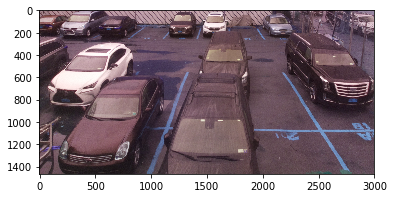

In [5]:

gray_image = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
# loop over of the detected object's bounding boxes and masks

spotList=spots.spot_list
spotMaskList=[]
for i in spotList:
    mask=get_mask_array_of_parking_spot(gray_image, i, 1) # 255 shows up as white on image 
    spotMaskList.append(mask)

plt.imshow(crop) 


In [6]:
'''
inputs:
    mask : It is a matrix of mask for the a single car in which pixles with that are set to true if there is mask else to false
    spot : It is a matrix for a singel spot whihc has 1 where the spots is and 0 where it isn't
    
output:
    true: if the mask is in the spot
    false: if the mask is not in the spot
'''
def has_car(mask,spot):
    #setting the pixels with value other than 0 because while doing the comparsion we only want to count common 1's
    spot[spot==0]=2
    # countign the common 1's
    common=((spot==mask)==1).sum()
    # getting the number of 1's in the spot
    spot_n=(spot==1).sum()
    # calculting the percentage
    percent=common/spot_n
   
    spot[spot==2]=0
    if(percent>0.40):
        return True
    else:
        return False
    

In [7]:
fullSpots=[]
emptySpots=[]
maskList=[]
index1=[]
for i in range(0, r["rois"].shape[0]):
    # extract the class ID and mask for the current detection, then
    # grab the color to visualize the mask (in BGR format)
    classID = r["class_ids"][i]
    mask = r["masks"][:, :, i]
    maskList.append(mask)
    for j in spotMaskList:
        if has_car(mask,j):
            fullSpots.append(j)
            spotMaskList.remove(j)
            break
        



In [8]:
emptySpots=spotMaskList

In [12]:

color1=[0,0,1]
color2=[0,1,0]
for i in fullSpots:
    new_image = visualize.apply_mask(crop, i,color1, alpha=1)

for i in emptySpots:
    new_image = visualize.apply_mask(new_image, i,color2, alpha=1)    

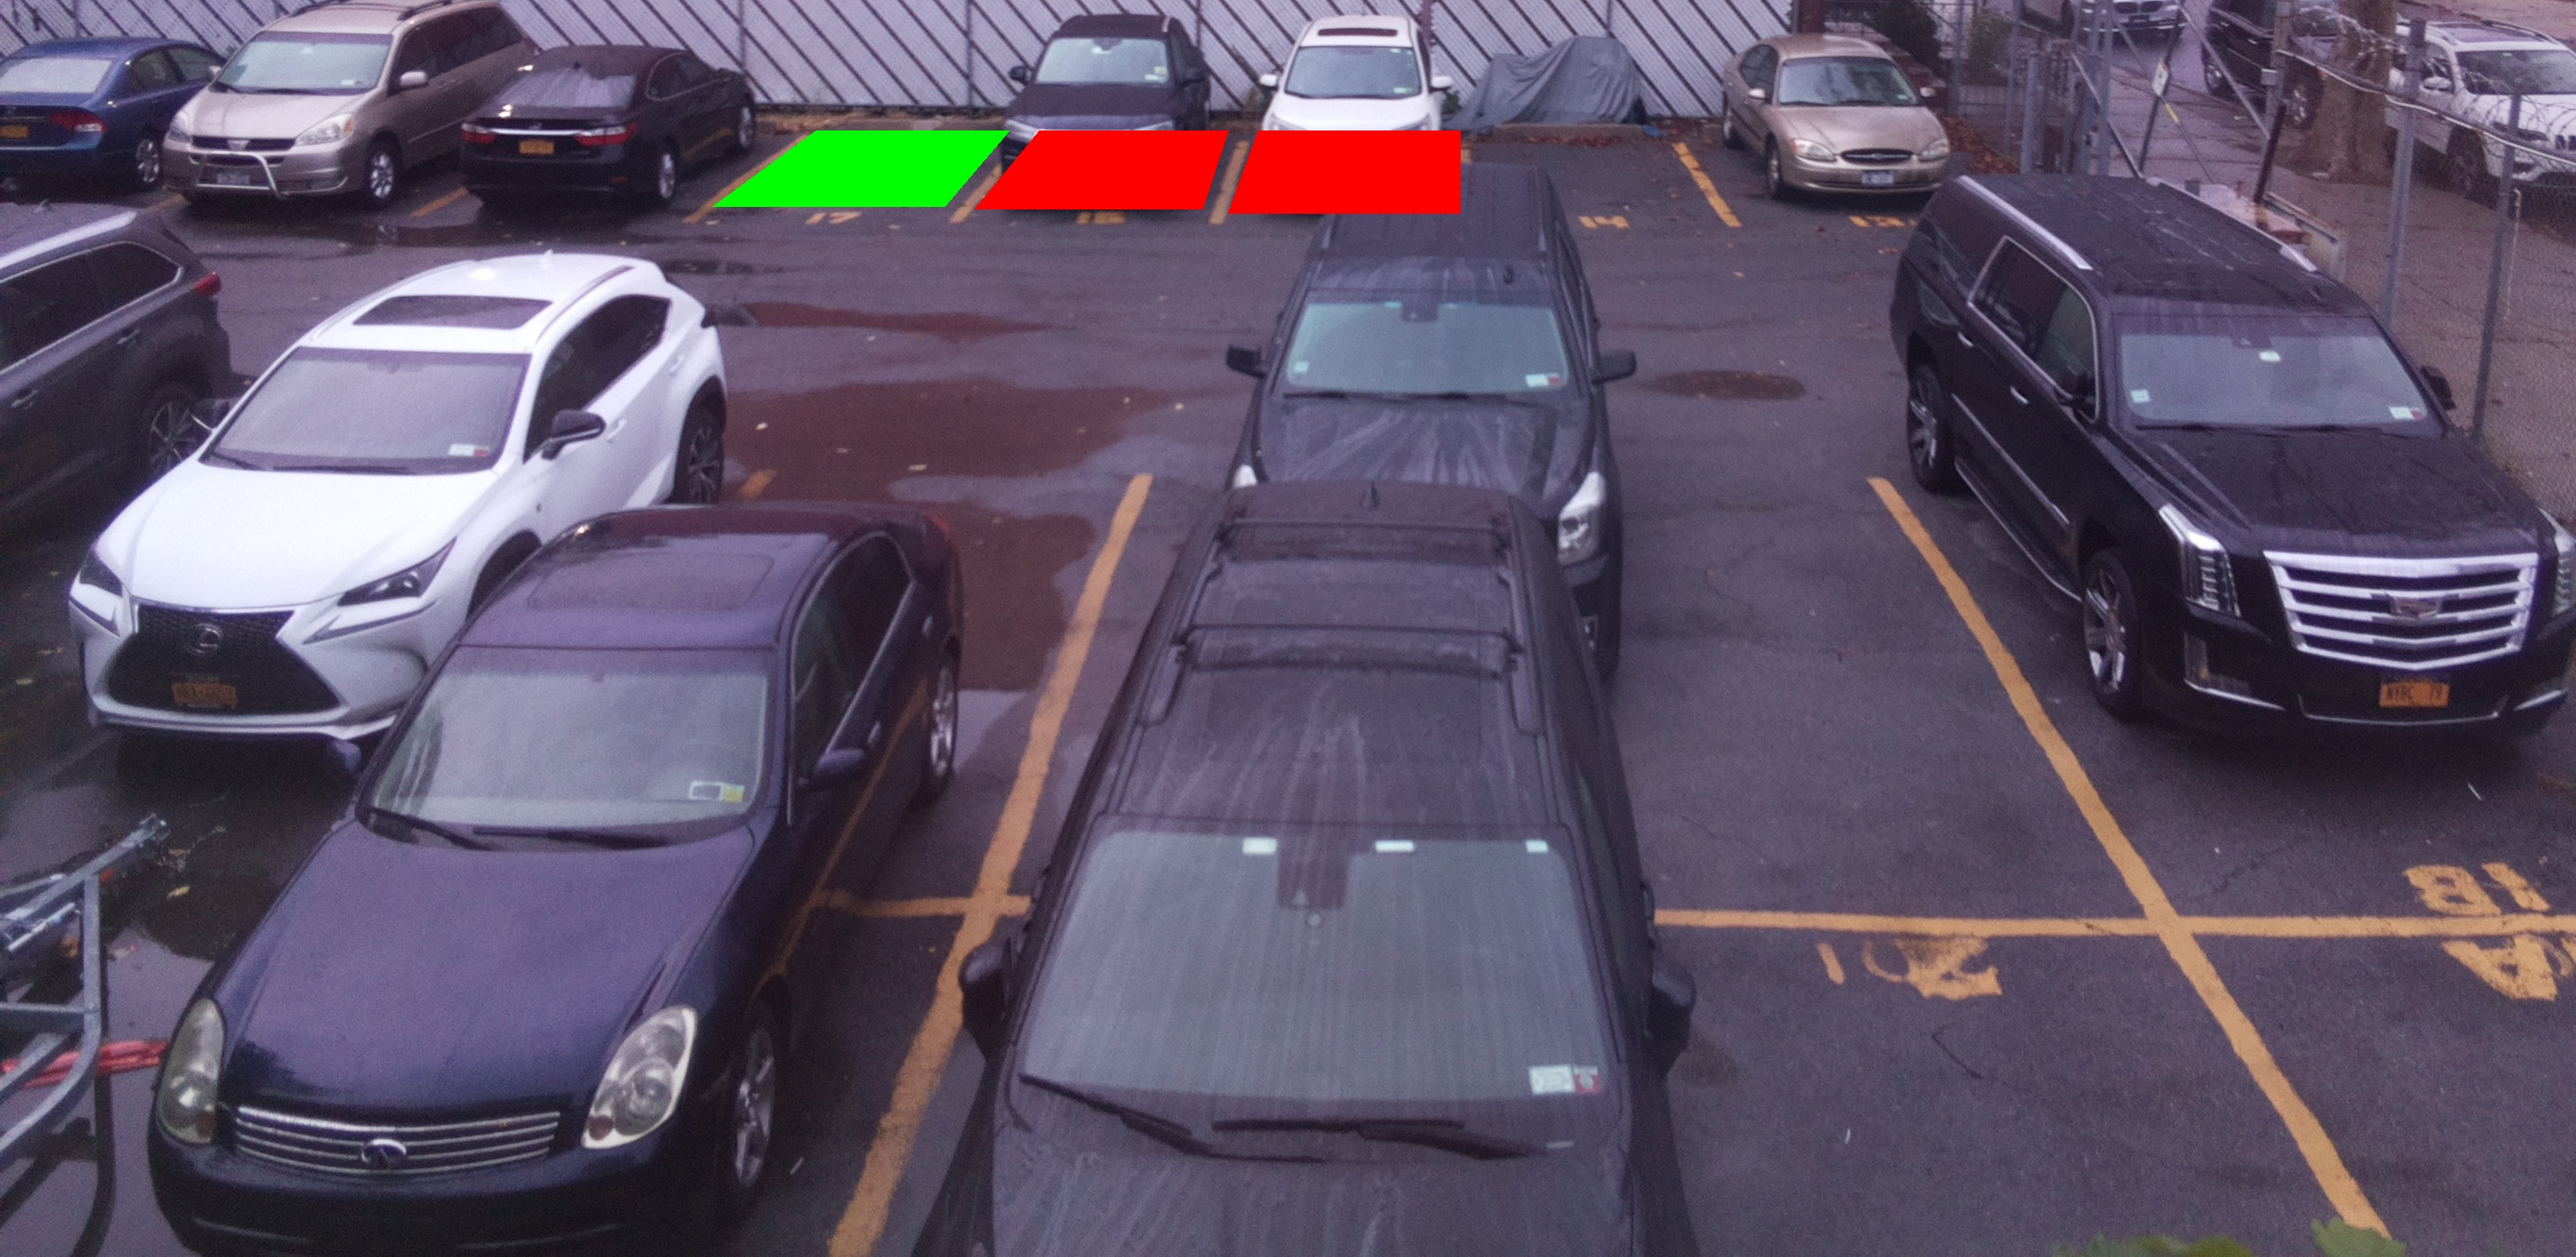

In [13]:
#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
 
# # loop over the predicted scores and class labels
# for i in range(0, len(r["scores"])):
#     # extract the bounding box information, class ID, label, predicted
#     # probability, and visualization color
#     (startY, startX, endY, endX) = r["rois"][i]
#     classID = r["class_ids"][i]
#     label = 'car'
#     score = r["scores"][i]
#     color = COLOR

#     # draw the bounding box, class label, and score of the object
#     cv2.putText(image, cv2.FONT_HERSHEY_SIMPLEX,0.6, color, 2)

cv2.imwrite('car_output_w_mask.jpg', new_image)
cv2.destroyAllWindows()
Image('car_output_w_mask.jpg')


In [ ]:
int(True)

# Run the below cell only to remove the pre-trained model

In [ ]:
os.remove('mask_rcnn_coco.h5')
print("Pretrained Model Removed from the folder, Download to again to run the model")